# Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
import torchvision
from torch.nn import functional as F
import re
import collections
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 5070


# Recurrent Neural Network

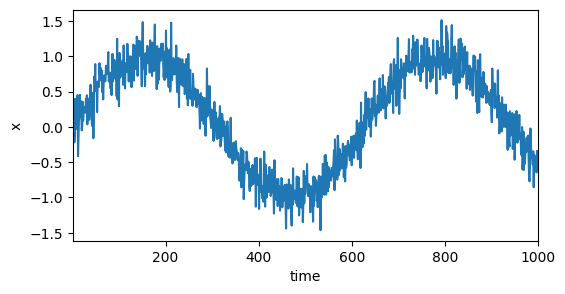

In [2]:
class Data(torch.utils.data.Dataset):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        super().__init__()
        self.batch_size = batch_size    
        self.tau = tau
        self.num_train = num_train
        self.T = T
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2

    def get_dataloader(self, train):
        features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)

    def get_tensorloader(self, tensors, train, idx_slice):
        dataset = torch.utils.data.TensorDataset(
            tensors[0][idx_slice], tensors[1][idx_slice]
        )
        return torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=train
        )

data = Data()
plt.figure(figsize=(6, 3))
plt.plot(data.time, data.x)
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, 1000])
plt.show()

In [3]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

Epoch [10/100], Train Loss: 0.0515, Val Loss: 0.0501
Epoch [20/100], Train Loss: 0.0515, Val Loss: 0.0498
Epoch [30/100], Train Loss: 0.0508, Val Loss: 0.0496
Epoch [40/100], Train Loss: 0.0511, Val Loss: 0.0499
Epoch [50/100], Train Loss: 0.0509, Val Loss: 0.0496
Epoch [60/100], Train Loss: 0.0508, Val Loss: 0.0493
Epoch [70/100], Train Loss: 0.0512, Val Loss: 0.0495
Epoch [80/100], Train Loss: 0.0517, Val Loss: 0.0500
Epoch [90/100], Train Loss: 0.0520, Val Loss: 0.0493
Epoch [100/100], Train Loss: 0.0507, Val Loss: 0.0495
Average Test Loss: 0.0495


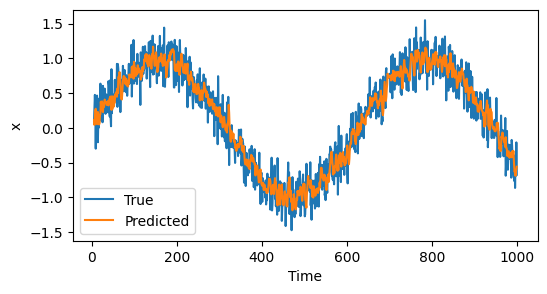

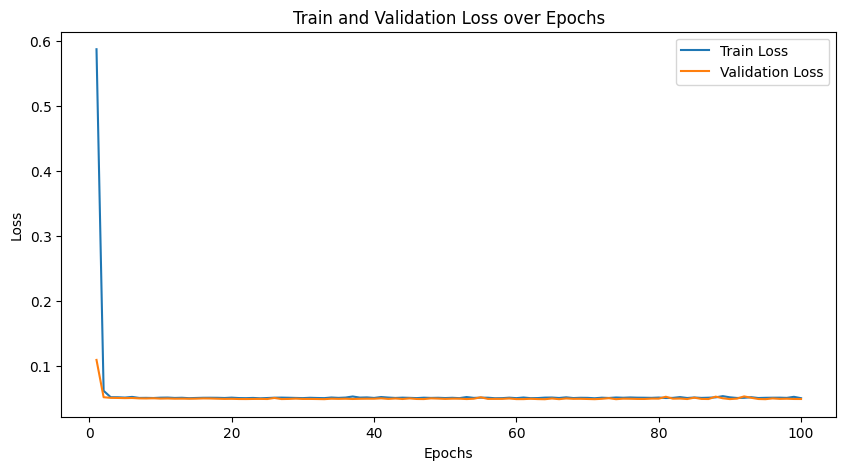

In [4]:
model = LinearRegression(data.tau, 1)
# Train model on data
data = Data()
train_loader = data.get_dataloader(train=True)
test_loader = data.get_dataloader(train=False)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    model.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()
        avg_val_loss = epoch_val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Evaluate model
with torch.no_grad():
    total_loss = 0
    for features, labels in test_loader:
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Average Test Loss: {avg_loss:.4f}')

# Plot predictions
with torch.no_grad():
    predictions = model(data.features).squeeze()
    plt.figure(figsize=(6, 3))
    plt.plot(data.time[data.tau:], data.x[data.tau:], label='True')
    plt.plot(data.time[data.tau:], predictions, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('x')
    plt.legend()
    plt.show()

# Visualize train and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()

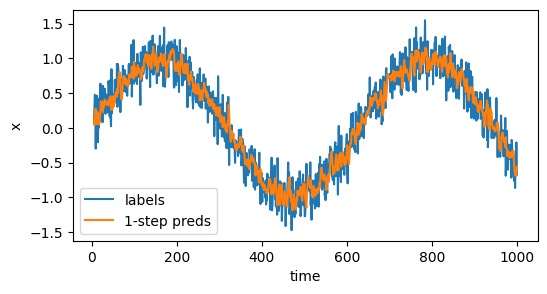

In [5]:
onestep_preds = model(data.features).detach().numpy()
plt.figure(figsize=(6, 3))
plt.plot(data.time[data.tau:], data.labels.numpy(), label='labels')
plt.plot(data.time[data.tau:], onestep_preds, label='1-step preds')
plt.xlabel('time')
plt.ylabel('x')
plt.legend()
plt.show()

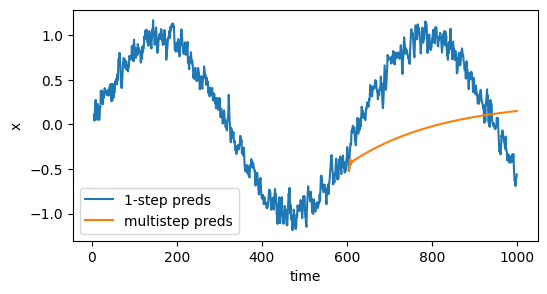

In [6]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

plt.figure(figsize=(6, 3))
plt.plot(data.time[data.tau:], onestep_preds, label='1-step preds')
plt.plot(data.time[data.num_train+data.tau:], multistep_preds[data.num_train+data.tau:], label='multistep preds')
plt.xlabel('time')
plt.ylabel('x')
plt.legend()
plt.show()

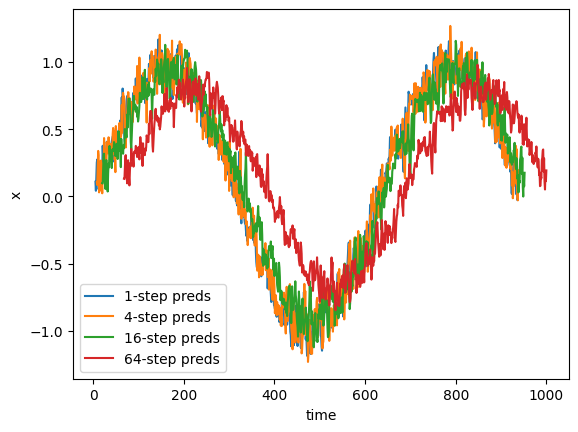

<Figure size 600x300 with 0 Axes>

In [7]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
for idx, k in enumerate(steps):
    x = data.time[data.tau + k - 1:]
    y = preds[k - 1].detach().numpy()
    min_len = min(len(x), len(y))
    plt.plot(x[:min_len], y[:min_len], label=f'{k}-step preds')
plt.xlabel('time')
plt.ylabel('x')
plt.legend()
plt.figure(figsize=(6, 3))
plt.show()

# Converting Raw Text into Sequences

## Reading Dataset

In [8]:
def preprocess(text):
    return re.sub('[^A-Za-z]+', ' ', text).lower()


In [23]:
text = ""
full_text = ""
with open('The Time Machine - Sample.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()
    full_text = preprocess(raw_text)
    text = full_text[:60]
data

' the project gutenberg ebook of the time machine this ebook '

## Tokenization

In [24]:
def tokenize(text):
    return list(text)

tokens = tokenize(text)
','.join(tokens[:30])

' ,t,h,e, ,p,r,o,j,e,c,t, ,g,u,t,e,n,b,e,r,g, ,e,b,o,o,k, ,o'

## Vocabulary

In [11]:
class Vocab: 
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

In [12]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [0, 21, 9, 6, 0, 17, 19, 16, 11, 6]
words: [' ', 't', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e']


## Putting it all together

In [13]:
def build(raw_text, vocab=None):
    tokens = tokenize(preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = build(raw_text)
len(corpus), len(vocab)

(192418, 28)

## Exploratory Language Statistics

In [14]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2477),
 ('and', 1311),
 ('of', 1285),
 ('i', 1268),
 ('a', 877),
 ('to', 766),
 ('in', 605),
 ('was', 554),
 ('that', 458),
 ('it', 452)]

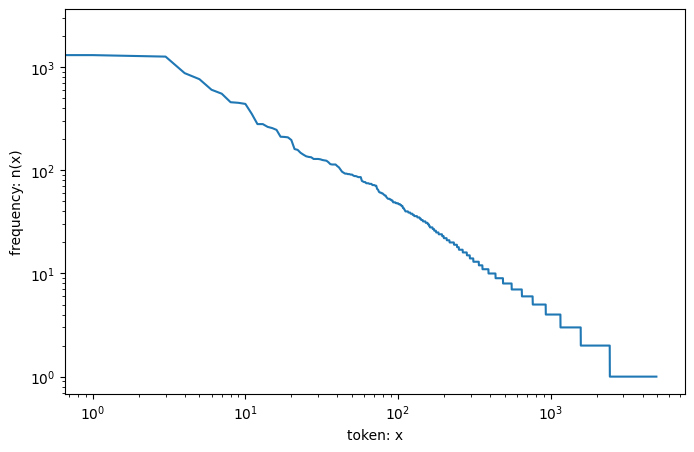

In [15]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.figure(figsize=(8, 5))
plt.plot(freqs)
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [16]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 344),
 ('in--the', 192),
 ('i--had', 130),
 ('and--the', 112),
 ('i--was', 112),
 ('the--time', 110),
 ('to--the', 101),
 ('it--was', 99),
 ('project--gutenberg', 88),
 ('as--i', 78)]

In [17]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 63),
 ('the--time--machine', 34),
 ('the--project--gutenberg', 33),
 ('the--medical--man', 24),
 ('project--gutenberg--electronic', 18),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('the--united--states', 14),
 ('seemed--to--me', 14)]

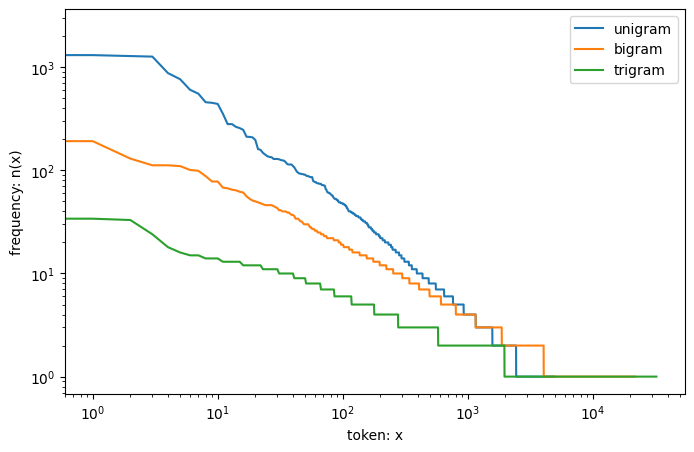

In [18]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plt.figure(figsize=(8, 5))
plt.plot(freqs, label='unigram')
plt.plot(bigram_freqs, label='bigram')
plt.plot(trigram_freqs, label='trigram')
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

The unigram, bigram and trigram graphs all follow Zipf's law albeit with different values of $\alpha$

# Language Models

In [48]:
class LanguageData(nn.Module):
    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.num_train = num_train
        self.num_val = num_val
        self.corpus, self.vocab = build(full_text)
        array = torch.tensor([corpus[i:i+num_steps+1]
                                for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:,:-1], array[:,1:]
    
    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(self.num_train, self.num_train+self.num_val)
        return self.get_tensorloader([self.X, self.Y], train, idx)
    
    def get_tensorloader(self, tensors, train, idx_slice):
        dataset = torch.utils.data.TensorDataset(
            tensors[0][idx_slice], tensors[1][idx_slice]
        )
        return torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, shuffle=train
        )

In [49]:
data = LanguageData(batch_size=16, num_steps=10)
for X, Y in data.get_dataloader(train=True):
    print('X:', X, 'Y:', Y)
    break

X: tensor([[ 2, 21,  0, 24, 16, 19, 12,  0, 22, 17],
        [ 0, 14,  2, 26,  0,  4, 16, 17, 26,  0],
        [10, 16, 22, 20, 15,  6, 20, 20,  0, 14],
        [20,  0, 19,  6,  2, 13, 13, 26,  0, 16],
        [21, 24,  6, 15, 21, 26,  0, 21,  9, 19],
        [12, 15, 16, 24,  0,  9, 16, 24,  0, 16],
        [ 6,  0, 20, 22, 19,  6, 13, 26,  0, 21],
        [ 0, 24, 19, 16, 15,  8,  0, 20, 10,  5],
        [22, 15, 10, 20, 21, 10,  4,  0,  3,  2],
        [ 0,  2, 15,  5,  0,  5, 22, 19,  2, 21],
        [13, 20,  0, 16,  7,  0, 17, 19,  6,  4],
        [ 6, 15, 21,  0, 14, 16, 14,  6, 15, 21],
        [ 2, 23,  6, 13, 13,  6, 19,  0, 20,  0],
        [ 0, 25, 10, 10, 10,  0, 21,  9,  6,  0],
        [ 6,  0, 16,  7,  0, 21,  9,  6,  0, 21],
        [ 8,  9, 21,  0,  4,  2, 14,  6,  0, 25]]) Y: tensor([[21,  0, 24, 16, 19, 12,  0, 22, 17, 16],
        [14,  2, 26,  0,  4, 16, 17, 26,  0, 10],
        [16, 22, 20, 15,  6, 20, 20,  0, 14, 16],
        [ 0, 19,  6,  2, 13, 13, 26,  0, 16

# Recurrent Neural Networks

## Calculating output of hidden states and output

Calculating hidden state $\vec{H_t} = \phi(\vec{X_t} \cdot \vec{W_{xh}} + \vec{H_{t-1}} \cdot \vec{W_{hh}} + \vec{b_h})$

In [36]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-0.3008,  0.9546, -0.8753, -1.1203],
        [-2.2328, -0.2826,  0.7661, -4.4933],
        [ 1.1762, -1.9137,  1.9228, -1.5062]])

In [37]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-0.3008,  0.9546, -0.8753, -1.1203],
        [-2.2328, -0.2826,  0.7661, -4.4933],
        [ 1.1762, -1.9137,  1.9228, -1.5062]])

## Implementation

In [38]:
class RNNScratch(nn.Module): 
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.sigma = sigma
        # Initialize weights and biases
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
    
    def forward(self, inputs, state=None):
        if state is None:
            # Initial state with shape: (batch_size, num_hiddens)
            state = torch.zeros((inputs.shape[1], self.num_hiddens),
                            device=inputs.device)
        else:
            state, = state
        outputs = []
        for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                            torch.matmul(state, self.W_hh) + self.b_h)
            outputs.append(state)
        return outputs, state

In [39]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [42]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## RNN-Based Language Model

### Using One-Hot Encoding

In [44]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

### Model Implementation

In [53]:
class RNNLMScratch(nn.Module): 
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.rnn = rnn
        self.vocab_size = vocab_size
        self.lr = lr
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
    
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)
    
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def clip_gradients(self, grad_clip_val, model):
        params = [p for p in model.parameters() if p.requires_grad]
        norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
        if norm > grad_clip_val:
            for param in params:
                param.grad[:] *= grad_clip_val / norm

    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict num_preds steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

In [56]:
data = LanguageData(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)

# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
num_epochs = 10  # You can increase this

num_epochs = 100  # Changed to 100 epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X, Y in data.get_dataloader(train=True):
        optimizer.zero_grad()
        outputs = model(X)  # outputs: (batch_size, num_steps, vocab_size)
        # Reshape for loss: (batch_size*num_steps, vocab_size)
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), Y.reshape(-1))
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data.get_dataloader(train=True))

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, Y_val in data.get_dataloader(train=False):
            val_outputs = model(X_val)
            v_loss = criterion(val_outputs.reshape(-1, val_outputs.shape[-1]), Y_val.reshape(-1))
            val_loss += v_loss.item()
    avg_val_loss = val_loss / len(data.get_dataloader(train=False))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 10, Train Loss: 15.6727, Val Loss: 15.6230
Epoch 20, Train Loss: 35.6924, Val Loss: 38.6683
Epoch 30, Train Loss: 24.1828, Val Loss: 29.8871
Epoch 40, Train Loss: 28.6806, Val Loss: 31.7030
Epoch 50, Train Loss: 24.3561, Val Loss: 20.2175
Epoch 60, Train Loss: 21.8993, Val Loss: 22.1907
Epoch 70, Train Loss: 23.1869, Val Loss: 25.3846
Epoch 80, Train Loss: 21.0832, Val Loss: 21.6686
Epoch 90, Train Loss: 18.5337, Val Loss: 18.6898
Epoch 100, Train Loss: 19.6927, Val Loss: 17.8104


In [58]:
model.predict('it has', 20, data.vocab)

'it hasrrrrrrrrrrrrrrrrrrrr'

## Concise Implementation

In [59]:
class RNN(nn.Module):  #@save
    """The RNN model implemented with high-level APIs."""
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        # Initialize the RNN layer 
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [60]:
class RNNLM(RNNLMScratch):  #@save
    """The RNN-based language model implemented with high-level APIs."""
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [61]:
data = LanguageData(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)

# Training loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
num_epochs = 10  # You can increase this

num_epochs = 100  # Changed to 100 epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X, Y in data.get_dataloader(train=True):
        optimizer.zero_grad()
        outputs = model(X)  # outputs: (batch_size, num_steps, vocab_size)
        # Reshape for loss: (batch_size*num_steps, vocab_size)
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), Y.reshape(-1))
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(data.get_dataloader(train=True))

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, Y_val in data.get_dataloader(train=False):
            val_outputs = model(X_val)
            v_loss = criterion(val_outputs.reshape(-1, val_outputs.shape[-1]), Y_val.reshape(-1))
            val_loss += v_loss.item()
    avg_val_loss = val_loss / len(data.get_dataloader(train=False))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 10, Train Loss: 24.8372, Val Loss: 20.8877
Epoch 20, Train Loss: 26.2842, Val Loss: 29.1166
Epoch 30, Train Loss: 29.1615, Val Loss: 25.4538
Epoch 40, Train Loss: 24.7756, Val Loss: 25.5949
Epoch 50, Train Loss: 24.9045, Val Loss: 21.0255
Epoch 60, Train Loss: 24.1860, Val Loss: 23.4812
Epoch 70, Train Loss: 19.7584, Val Loss: 19.4977
Epoch 80, Train Loss: 20.7012, Val Loss: 22.9252
Epoch 90, Train Loss: 25.5150, Val Loss: 27.9180
Epoch 100, Train Loss: 25.5549, Val Loss: 20.9250


In [66]:
model.predict('it has', 20, data.vocab)

'it hasllllllllllllllllllll'